<center>
<h1>Assignment #2 for Clustering: Sessa Empirical Estimator (SEE)</h1>
by Christian Abay-abay & Thristan Jay Nakila
</center>

### Instructions
1. **Read the Journals about the Sessa Empirical Estimator**
   - *Refer to:* `/journals`
2. **Convert the R codes into Python**
   - **R codes:** `SEE.R`
   - **Python conversion:** `SEE.ipynb`
3. **Perform the Sessa Empirical Estimator**
   - Use either simulated data or real-world datasets of your choice.
   - Generate insights based on the estimator's results.
4. **Experiment with clustering algorithms**
   - The estimator uses K-means by default. Try substituting it with a different clustering algorithm to derive new insights.
   - *Note:* K-means has its disadvantages.
5. **Compare the results**
   - Analyze and compare the outcomes between the estimator using K-means and the one using your chosen clustering algorithm.
6. **Develop callable functions**
   - Create a callable function for each step.
   - Verify that these functions produce the same results (and insights) as observed in your Jupyter Notebook.
7. **Collaborate with your thesis partner**

**Deadline:** Feb 25, 2025 at 11:59PM


***
<center>
<h2>Data Set Used</h2>
CSV file was extracted from `SEE.R`. File is found in `data/med-events.csv`. Special thank you to Ian S. for guiding us through this process.
</center>

***
<center>
<h2>SEE.R Conversion to Python Code</h2>
Since SEE.R is in a different language, we had two options to make use of its content. (1) Make use of the rpy2 library or (2) Convert the whole SEE.R into Python. We opted for the latter option as it would make it easier for us to debug and make further references of the code in the later stages of the notebook.
</center>

Data loaded with shape: (1080, 5)
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


/var/folders/dg/1pp6958j3vxc6dcf5gfcx9g80000gn/T/ipykernel_24587/31622283.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_work.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)


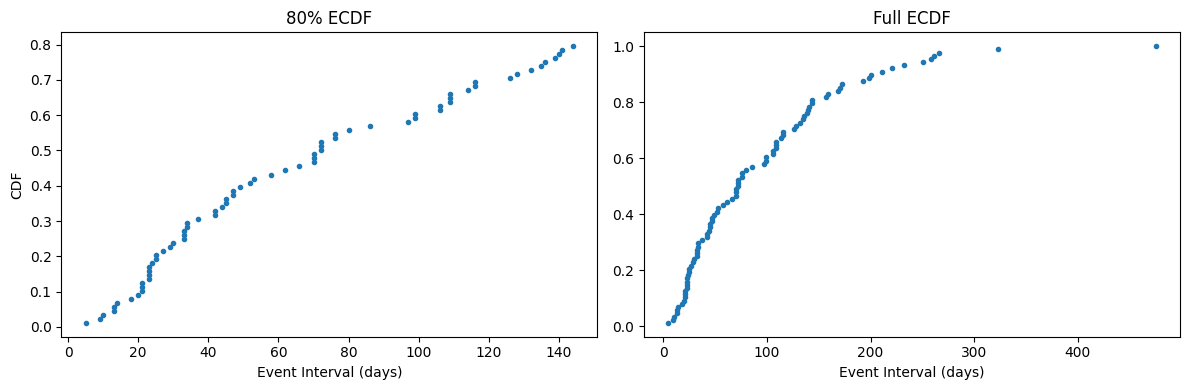

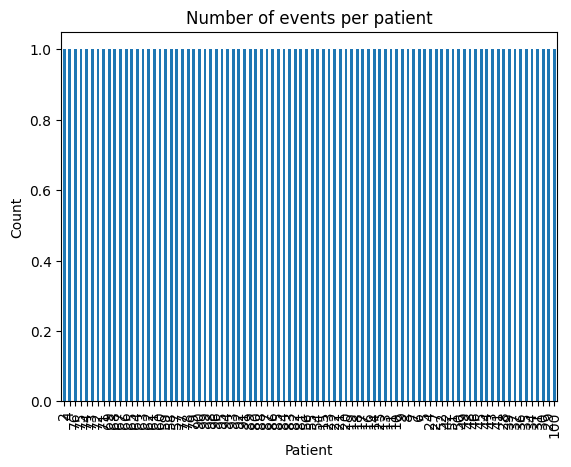

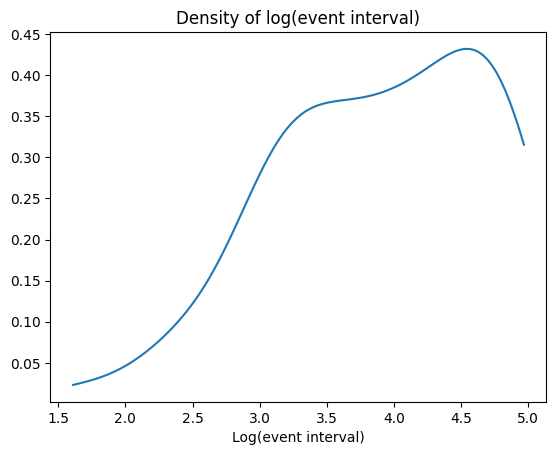

Optimal number of clusters (silhouette): 2
Cluster summary statistics:
   Cluster  Minimum  Maximum  Median
0        0        5       76    33.5
1        1       80      144   116.0


/var/folders/dg/1pp6958j3vxc6dcf5gfcx9g80000gn/T/ipykernel_24587/31622283.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_work.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)


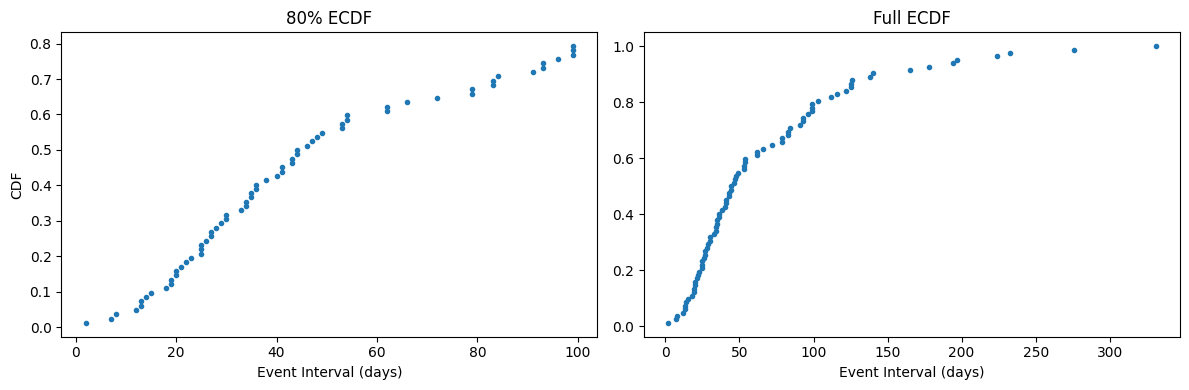

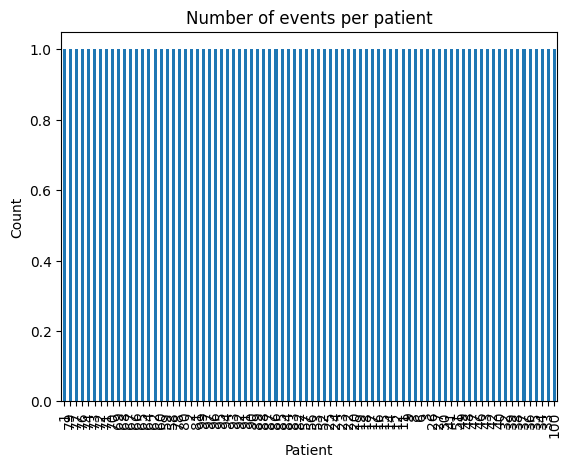

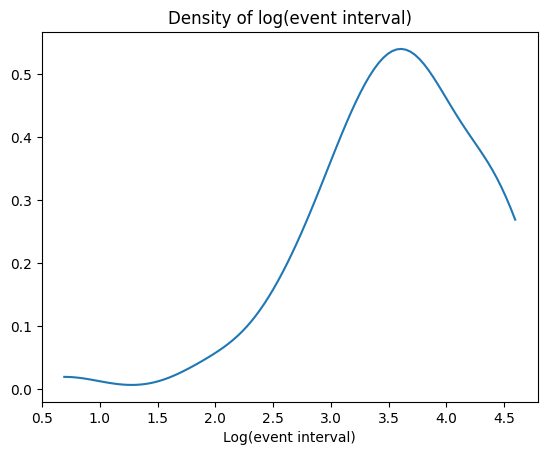

Optimal number of clusters (silhouette): 2
Cluster summary statistics:
   Cluster  Minimum  Maximum  Median
0        0       62       99    83.5
1        1        2       54    30.0


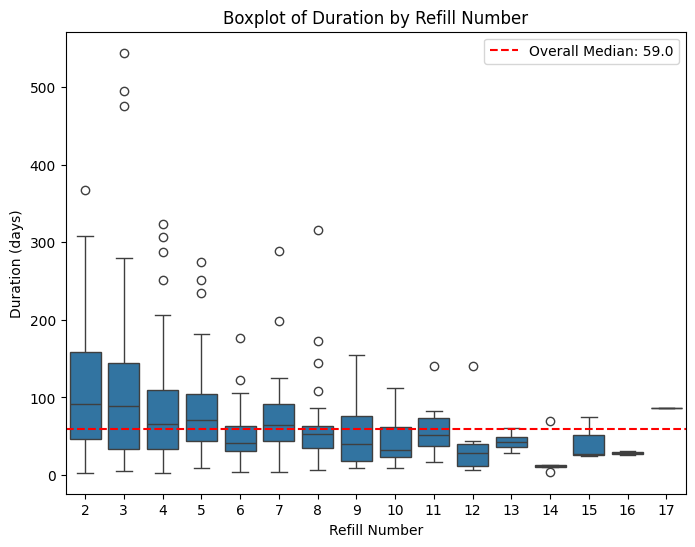

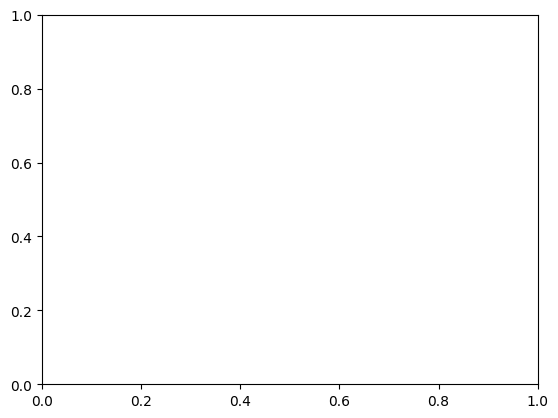

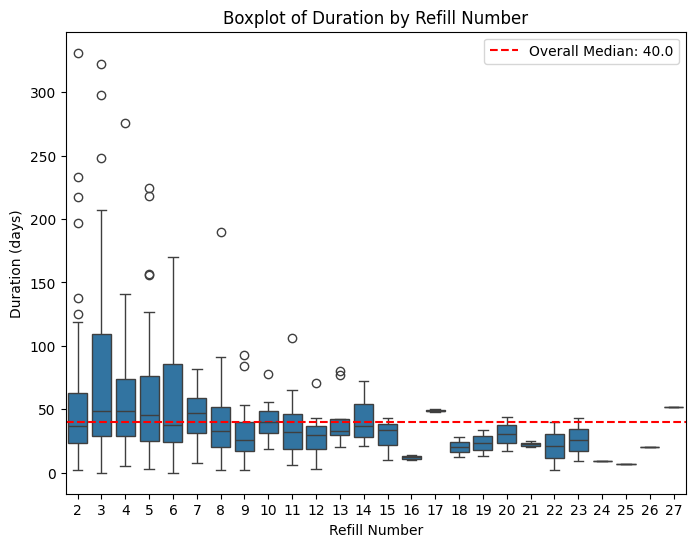

<Axes: >

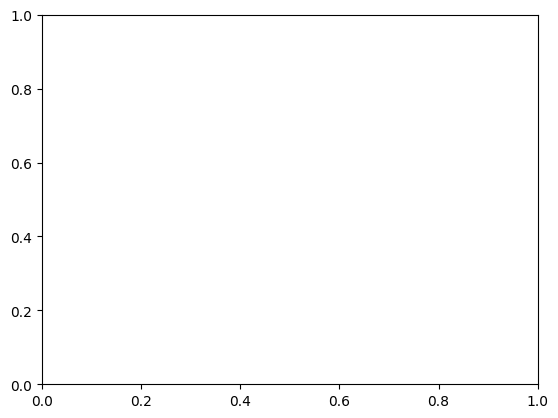

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

# -------------------------------
# Data Preparation
# -------------------------------
tidy = pd.read_csv("data/med-events.csv", sep="\t")
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format="%m/%d/%Y", errors='coerce')
print("Data loaded with shape:", tidy.shape)
print(tidy.head())

# -------------------------------
# Function: See
# -------------------------------
def See(drug, df):
    """
    Replicates the SEE.R functionality:
      - Filters data for the specified drug (by ATC code)
      - Computes time intervals between consecutive prescriptions (one per patient)
      - Builds the ECDF and retains the lower 80% (to remove outliers)
      - Performs density estimation on log-transformed intervals
      - Determines the optimal number of clusters via silhouette analysis on the 80% subset
      - Computes cluster summary statistics (min, max, median) for the original event intervals
      - Assigns an estimated prescription duration (the cluster’s median) to each patient
      - Merges the computed median duration and cluster assignment back to the original drug data
      
    Returns a DataFrame with the original drug data merged with the computed median duration and assigned cluster.
    """
    # 1. Filter for the desired drug
    subset = df[df['ATC'] == drug].copy()
    Drug_see_p0 = subset.copy()
    
    # 2. Compute previous prescription date per patient
    df_work = subset.sort_values(['pnr', 'eksd']).copy()
    df_work['prev_eksd'] = df_work.groupby('pnr')['eksd'].shift(1)
    df_work = df_work.dropna(subset=['prev_eksd'])
    
    # 3. Randomly sample one event per patient
    df_sampled = df_work.groupby('pnr', group_keys=False).apply(lambda x: x.sample(1)).reset_index(drop=True)
    df_sampled = df_sampled[['pnr', 'eksd', 'prev_eksd']].copy()
    
    # 4. Compute event interval (days)
    df_sampled['event_interval'] = (df_sampled['eksd'] - df_sampled['prev_eksd']).dt.days
    
    # 5. Compute the ECDF for event_interval
    intervals = np.sort(df_sampled['event_interval'].values)
    cdf = np.arange(1, len(intervals) + 1) / len(intervals)
    df_ecdf = pd.DataFrame({'x': intervals, 'cdf': cdf})
    
    # 6. Retain lower 80% of ECDF to remove outliers
    df_ecdf_80 = df_ecdf[df_ecdf['cdf'] <= 0.8]
    ni = df_ecdf_80['x'].max()  # cutoff threshold
    
    # Plot ECDFs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80['x'], df_ecdf_80['cdf'], marker='.', linestyle='none')
    plt.title("80% ECDF")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("CDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf['x'], df_ecdf['cdf'], marker='.', linestyle='none')
    plt.title("Full ECDF")
    plt.xlabel("Event Interval (days)")
    plt.tight_layout()
    plt.show()
    
    # Optional: Plot frequency of events per patient
    plt.figure()
    df_sampled['pnr'].value_counts().plot(kind='bar')
    plt.title("Number of events per patient")
    plt.xlabel("Patient")
    plt.ylabel("Count")
    plt.show()
    
    # 7. Filter sampled data to intervals <= cutoff (lower 80%)
    df_filtered = df_sampled[df_sampled['event_interval'] <= ni].copy()
    
    # 8. Density estimation on log-transformed intervals
    log_intervals = np.log(df_filtered['event_interval'])
    kde = gaussian_kde(log_intervals)
    x_dens = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_dens = kde(x_dens)
    plt.figure()
    plt.plot(x_dens, y_dens)
    plt.title("Density of log(event interval)")
    plt.xlabel("Log(event interval)")
    plt.show()
    
    # 9. Clustering on filtered data
    scaler = StandardScaler()
    X = scaler.fit_transform(df_filtered[['event_interval']])
    sil_scores = {}
    for k in range(2, 7):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        sil_scores[k] = score
    optimal_k = max(sil_scores, key=sil_scores.get)
    print("Optimal number of clusters (silhouette):", optimal_k)
    
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_filtered['Cluster'] = kmeans_final.fit_predict(X)
    
    # 10. Compute cluster summary statistics on original event_interval values
    cluster_stats = df_filtered.groupby('Cluster')['event_interval'].agg(['min', 'max', 'median']).reset_index()
    cluster_stats = cluster_stats.rename(columns={'min': 'Minimum', 'max': 'Maximum', 'median': 'Median'})
    print("Cluster summary statistics:")
    print(cluster_stats)
    
    # 11. Assign each patient's event_interval an estimated duration based on clusters
    def assign_cluster(interval):
        for idx, row in cluster_stats.iterrows():
            if row['Minimum'] <= interval <= row['Maximum']:
                return row['Median'], row['Cluster']
        # Fallback: use median from most common cluster if no match
        most_common_cluster = cluster_stats['Cluster'].value_counts().idxmax()
        median_val = cluster_stats.loc[cluster_stats['Cluster'] == most_common_cluster, 'Median'].values[0]
        return median_val, most_common_cluster

    df_sampled[['Assigned_Median', 'Assigned_Cluster']] = df_sampled['event_interval'].apply(
        lambda x: pd.Series(assign_cluster(x))
    )
    df_sampled['test'] = np.round(df_sampled['event_interval'] - df_sampled['Assigned_Median'], 1)
    
    # 12. Merge the assigned values back to the original drug subset
    Drug_see_p3 = df_sampled[['pnr', 'Assigned_Median', 'Assigned_Cluster']].copy()
    final_result = Drug_see_p0.merge(Drug_see_p3, on='pnr', how='left')
    final_result['Assigned_Median'] = pd.to_numeric(final_result['Assigned_Median'], errors='coerce')
    most_common_cluster = cluster_stats['Cluster'].value_counts().idxmax()
    fallback_median = cluster_stats.loc[cluster_stats['Cluster'] == most_common_cluster, 'Median'].values[0]
    final_result['Assigned_Median'] = final_result['Assigned_Median'].fillna(fallback_median)
    final_result['Assigned_Cluster'] = final_result['Assigned_Cluster'].fillna(0).astype(int)
    
    return final_result

# -------------------------------
# Function: see_assumption
# -------------------------------
def see_assumption(df):
    """
    Visualizes refill durations (difference between consecutive prescription dates)
    by plotting them against the refill number.
    """
    df_assump = df.sort_values(['pnr', 'eksd']).copy()
    df_assump['prev_eksd'] = df_assump.groupby('pnr')['eksd'].shift(1)
    df_assump['p_number'] = df_assump.groupby('pnr').cumcount() + 1
    df_assump = df_assump[df_assump['p_number'] >= 2].copy()
    df_assump = df_assump[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    df_assump['Duration'] = (df_assump['eksd'] - df_assump['prev_eksd']).dt.days
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_assump)
    plt.title("Boxplot of Duration by Refill Number")
    plt.xlabel("Refill Number")
    plt.ylabel("Duration (days)")
    overall_median = df_assump['Duration'].median()
    plt.axhline(y=overall_median, color='red', linestyle='--',
                label=f'Overall Median: {overall_median:.1f}')
    plt.legend()
    plt.show()
    
    return plt.gca()

# -------------------------------
# Example usage:
# -------------------------------
medA = See("medA", tidy)
medB = See("medB", tidy)

see_assumption(medA)
see_assumption(medB)
